# Sheet 12

In [14]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Pauli
from operator import not_

## 1)

In [15]:
def get_base():
    qc = QuantumCircuit(7,name="state_prep")
    qc.cx(0,6)
    qc.cx(6,0)
    qc.barrier()
    qc.h([0,1,2])
    qc.barrier()
    qc.cx(6,[5,4])
    qc.barrier()
    qc.cx(0,[3,5,6])
    qc.barrier()
    qc.cx(1,[3,4,6])
    qc.barrier()
    qc.cx(2,[3,4,5])
    return qc.to_instruction()
def get_base_inverse():
    qc = QuantumCircuit(7,name="Comp. Basis")
    qc.cx(2,[3,4,5])
    qc.cx(1,[3,4,6])
    qc.cx(0,[3,5,6])
    qc.cx(6,[5,4])
    qc.h([0,1,2])
    qc.cx(6,0)
    qc.cx(0,6)
    return qc.to_instruction()

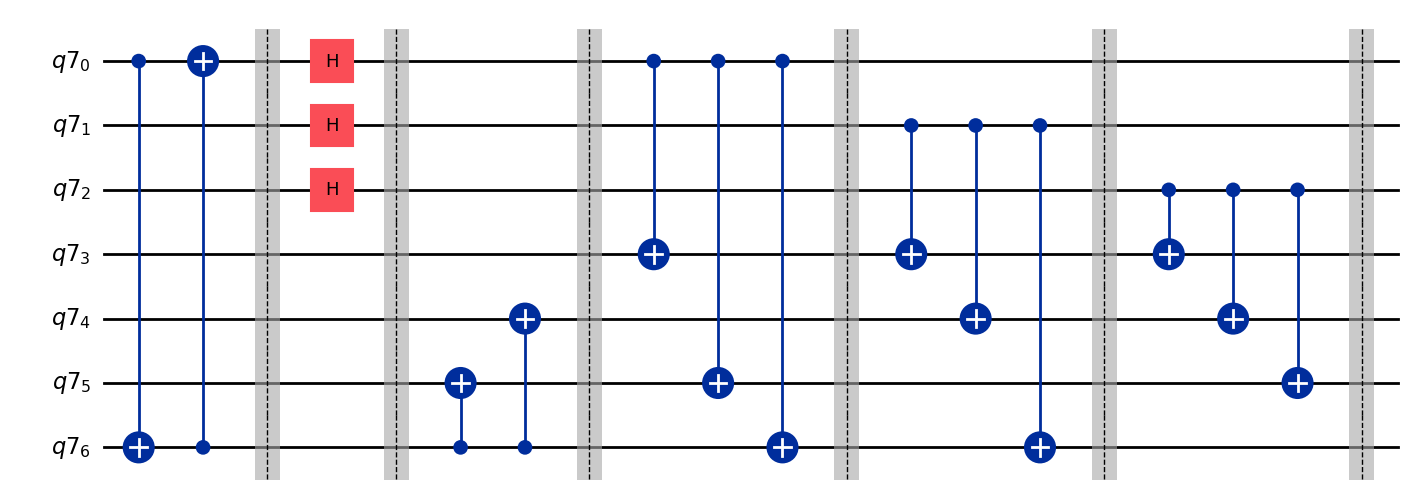

In [16]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)
# qc.x(0)
qc.append(get_base(),qr)

qc.barrier()
# qc.append(get_base_inverse(),qr)
qc.decompose().draw('mpl')

In [17]:
Statevector.from_instruction(qc).draw('latex')

<IPython.core.display.Latex object>

## 4)

To measure the stabilizers code from sheet 10 is reused. The PauliString libary form qiskit is used for convenience. The following notation is assumed $g=IXZZX = I_5 X_4 Z_3 Z_2 X_1$, where the subscript corresponds to the quibt the gate is applied on.


In [18]:
def pauli_basetrafo(circuit,qubit_idx,pauli,qr,inverse=False):

    if pauli.x[qubit_idx]:
        if pauli.z[qubit_idx]:
            # Measure Y
            circuit.rx((-1*inverse + not_( inverse))*np.pi/2,qubit_idx)
        else:
            # Measure X
            circuit.h(qr[qubit_idx]) 
    return


In [19]:
def pauli_measurement(circuit, pauli, qr,anchilla, ):
    num_qubits = pauli.num_qubits
    for qubit_idx in range(num_qubits):
        if pauli[qubit_idx] == Pauli('I'):
            continue 
        pauli_basetrafo(circuit,qubit_idx,pauli,qr)
        circuit.cx(qubit_idx,anchilla)
        pauli_basetrafo(circuit,qubit_idx,pauli,qr,inverse=True)
    return circuit

In [20]:
def measure_multi_pauli(n_qubits,n,gs):
    qc = QuantumCircuit(n_qubits,name="pauli_measurement")
    qubits = list(range(n_qubits))
    qr = qubits[:n]
    a = qubits[n:]

    for i in range(len(gs)):
        pauli_measurement(qc, gs[i], qr,a[i]   )
    return qc.to_instruction()

Here are the stabilizers defined:

In [21]:
gs = [Pauli('IIIXXXX'),Pauli('IXXIIXX'),Pauli('XIXIXIX'),Pauli('IIIZZZZ'),Pauli('IZZIIZZ'),Pauli('ZIZIZIZ')]

In [22]:
sim = AerSimulator(method='statevector')

In [305]:
def get_random_error(qc,qr,gates=['X','Y','Z']):
    n = len(qr)
    qubit_to_apply_error = np.random.randint(n)
    operation = np.random.randint(len(gates))
    supported= {'X': qc.x,'Y': qc.y,'Z': qc.z}
    supported[gates[operation]](qubit_to_apply_error)
    return gates[operation],qubit_to_apply_error

In the following is the logic for the errorcorrection implementet. Probably a little bit overengineered.

In [306]:
def get_cases(qc,qr,):
    base_cases_keys = np.array([f"{i:03b}"[::-1] for i in range(1,len(qr)+1)])
    base_casese_vals = [len(qr)-i-1  for i in range(0,len(qr))]
    cases = {}
    for key, val in zip(base_cases_keys,base_casese_vals):
        cases["000"+key] = (qc.z,val)
        cases[key+"000"] = (qc.x,val)
        cases[key+key] = (qc.y,val)
    return cases


In [343]:
def correction(qc,qr,a,cr,cases,gs):
    qc.measure(a,cr)
    qc.append(measure_multi_pauli(qc.num_qubits,len(qr),gs),qr[:]+a[:]) #resetting the anchillas
    counts = sim.run(transpile(qc, sim),shots=1000).result().get_counts()
    assert len(list(counts.keys())) ==1
    cases[list(counts.keys())[0][len(qr)+1:]][0](qr[cases[list(counts.keys())[0][len(qr)+1:]][1]])
    

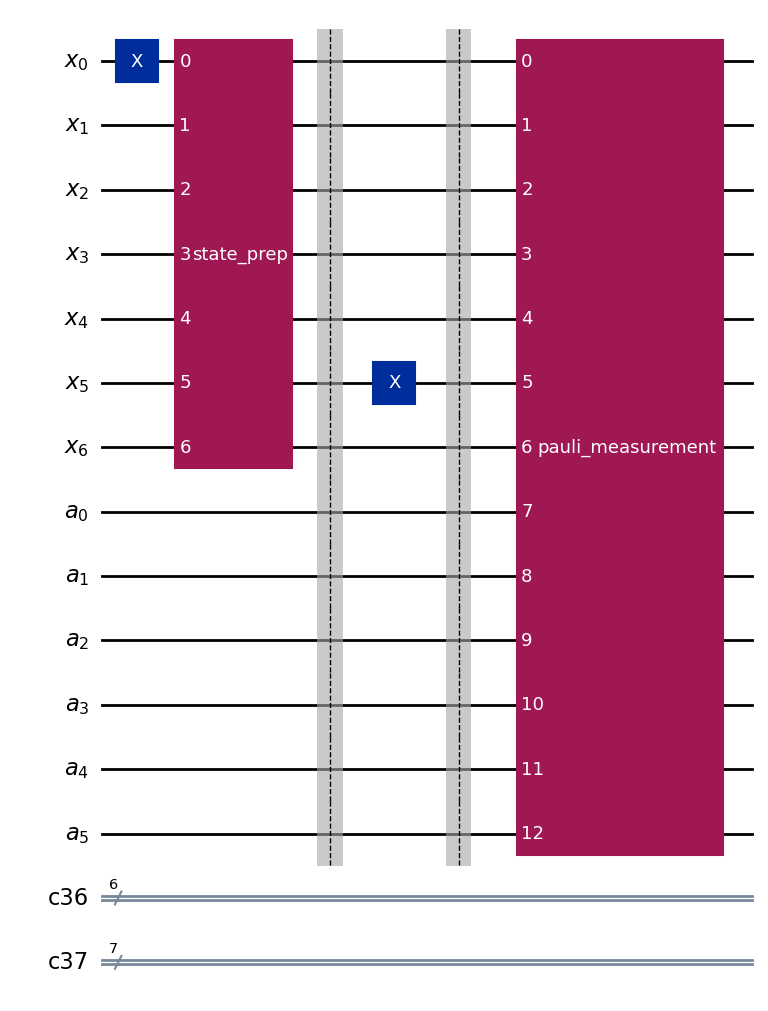

In [351]:
qr = QuantumRegister(7,'x')
a = QuantumRegister(6,'a')
cr = ClassicalRegister(6)
cr1 = ClassicalRegister(7)
qc = QuantumCircuit(qr,a,cr,cr1)
pauli_measurment = measure_multi_pauli(7+6,7,gs)
qc.x(0)
qc.append(get_base(),qr)
qc.barrier()
error_pos = get_random_error(qc,qr)
qc.barrier()

qc.append(pauli_measurment,qr[:]+a[:])
qc.draw('mpl')
# Statevector.from_instruction(qc).draw('latex')


Now are the errors corrected. For now I assume that MCMT gates are allowed, and that the phase pick up from $Y = iXZ$ is irrelevant.

In [352]:
cases = get_cases(qc,qr)
correction(qc,qr,a,cr,cases,gs)

invert to computational basis

In [353]:

qc.append(get_base_inverse(),qr)

In [354]:
error_pos

('X', 5)

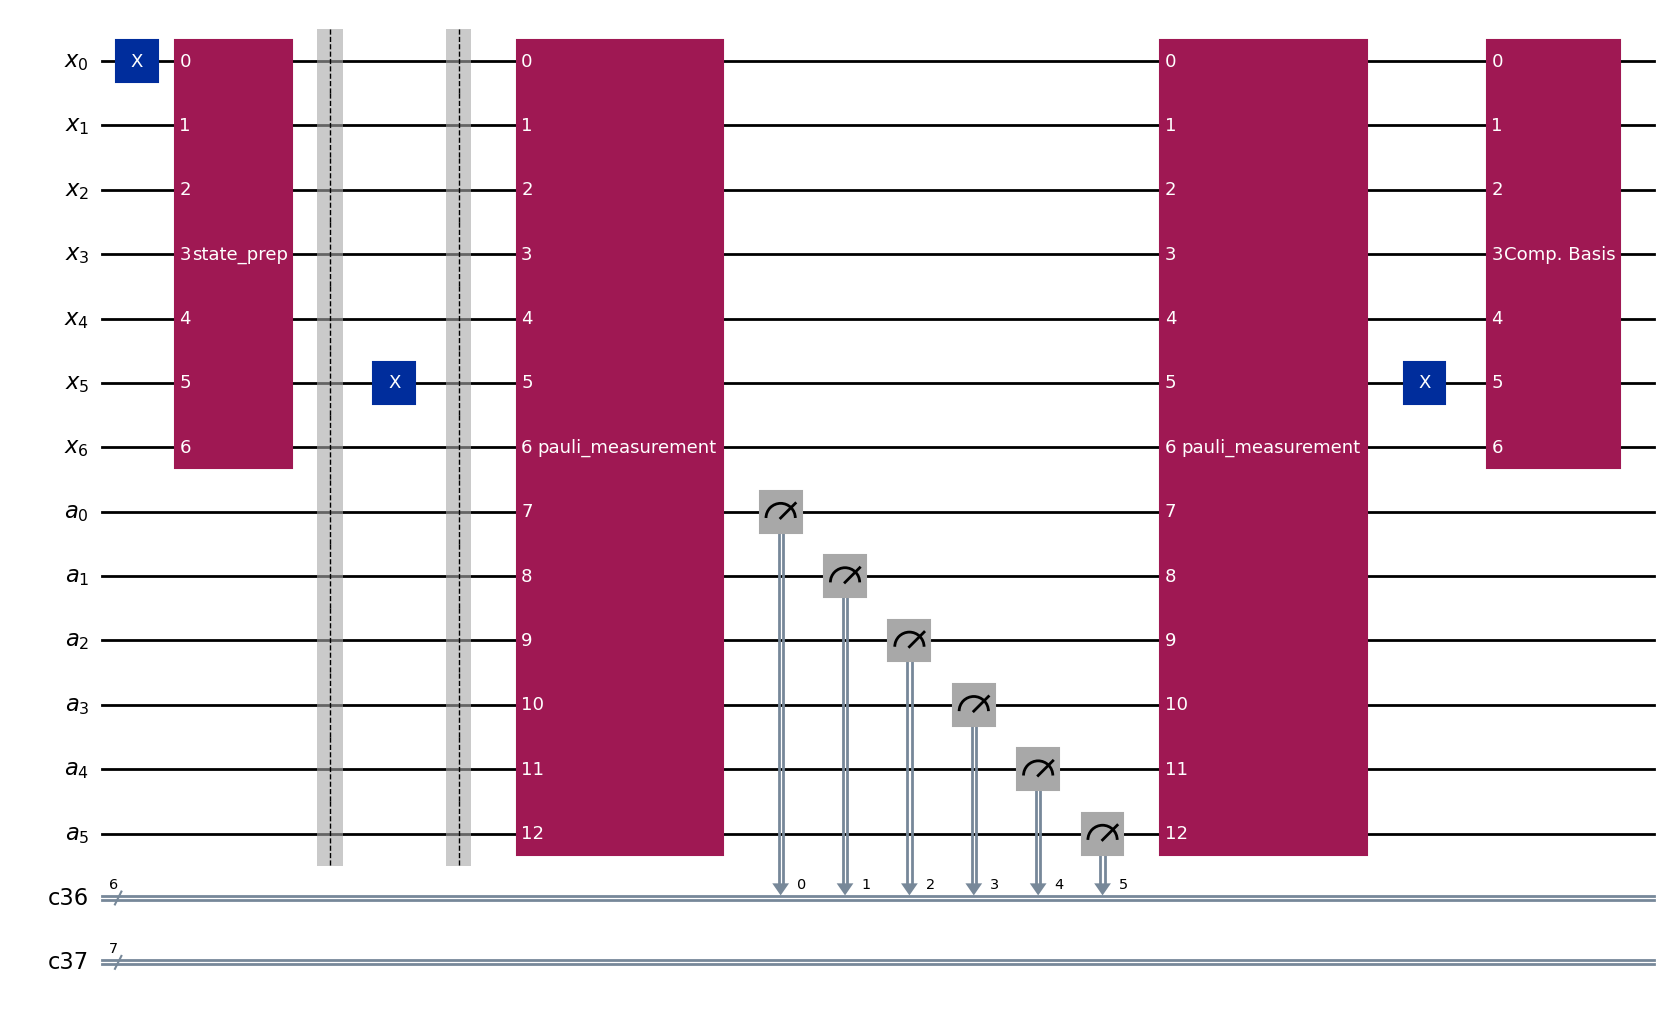

In [355]:
qc.draw('mpl')

One can see that the same gate which produces the error is applied again.
Measuring yields the expected result.

In [356]:
qc.measure(a,cr)
qc.measure(qr,cr1)
sim.run(transpile(qc, sim),shots=1000).result().get_counts()

{'0000001 000000': 1000}